# mnist

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from vi_svi_class_experiments import run_methods
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/multiclass/mnist_scale(60000,780).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/multiclass/mnist_scale_test(10000,780).txt')
data_name = 'mnist'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

y_tr = (y_tr %2 == 0).astype(float)
y_test = (y_test %2 == 0).astype(float)

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape
print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 10000
of features: 778
mnist


## K-Means cluster centers

In [3]:
ind_num = 300
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
with open('../plots/vi_vs_svi_class/'+ data_name +'_title.txt', 'w') as f:
    title = data_name + ' dataset, ' + 'n = ' + str(num) + ', d = ' + str(dim) + ', m = ' + str(ind_num)
    f.write(title)

In [4]:
cov_params = np.array([150., 200., 0.01])

## svi-L-BFGS-B-c method

In [20]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [21]:
opts = {'mode': 'full', 'maxiter': 200, 'mydisp': False}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [22]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=10)

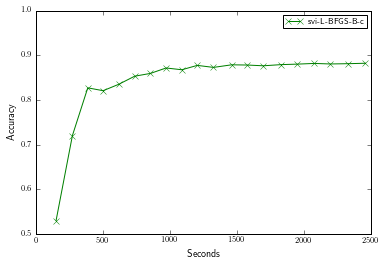

In [23]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.5, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method

In [10]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=7)

Hyper-parameters at iteration 0 : [  1.50000000e+02   2.00000000e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.01226585e+02   2.37740161e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [  5.30534752e+01   2.51815527e+02   1.00000000e-02]
Hyper-parameters at iteration 3 : [  3.97908728e+01   2.53518488e+02   1.00000000e-02]
Hyper-parameters at iteration 4 : [  3.71876622e+01   2.53819796e+02   1.00000000e-02]
	Hyper-parameters at outter iteration 0 : [  3.81358301e+01   2.53711072e+02   1.00000000e-02]
Hyper-parameters at iteration 0 : [  3.81358301e+01   2.53711072e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  3.29963362e+01   2.54479883e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [  3.33467380e+01   2.54427768e+02   1.00000000e-02]
Hyper-parameters at iteration 3 : [  3.33399630e+01   2.54428809e+02   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  3.33286619e+01   2.54430859e+02   1.00000000e-02]
Hyper-parameters at iterati

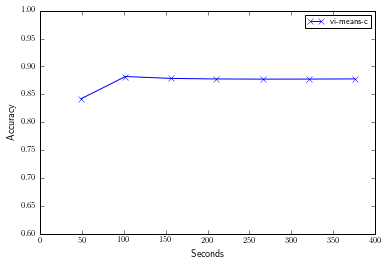

In [11]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подберем шаг для метода

In [28]:
results = []
steps = [2., 1., 0.5, 0.3, 0.1, 0.01]
for step in steps:
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': False, 'batch_size': 200, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2
3
4
5


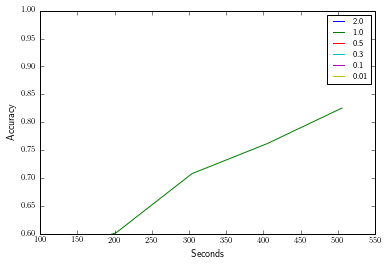

In [29]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=4)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0., 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [30]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 100, 'verbose': True, 'batch_size': 200, 
        'step_rate': 1., 'print_freq':1}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  50 :
	Gradient norm 23.4228202917
Iteration  100 :
	Gradient norm 22.7249890059
Iteration  150 :
	Gradient norm 23.8282245924
Iteration  200 :
	Gradient norm 25.4792721019
Iteration  250 :
	Gradient norm 31.2177743341
Iteration  300 :
	Gradient norm 19.9198783927
Iteration  350 :
	Gradient norm 31.4732613346
Iteration  400 :
	Gradient norm 19.9995188911
Iteration  450 :
	Gradient norm 15.2013645099
Iteration  500 :
	Gradient norm 18.7355324636
Iteration  550 :
	Gradient norm 17.5951876982
Iteration  600 :
	Gradient norm 25.7272372386
Iteration  650 :
	Gradient norm 16.1253184703
Iteration  700 :
	Gradient norm 28.1819553307
Iteration  750 :
	Gradient norm 13.9651183437
Iteration  800 :
	Gradient norm 19.6835281795
Iteration  850 :
	Gradient norm 18.4336359007
Iteration  900 :
	Gradient norm 12.2852385119
Iteration  950 :
	Gradient norm 25.7352182163
Iteration  1000 :
	Gradient norm 16.7524589539
Iteration  1050 :
	Gradient norm 11.757683168
Iteration  1100 :
	Gradient norm 1

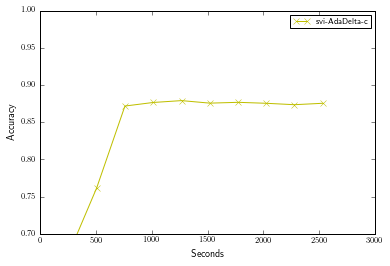

In [31]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=10)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.7, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

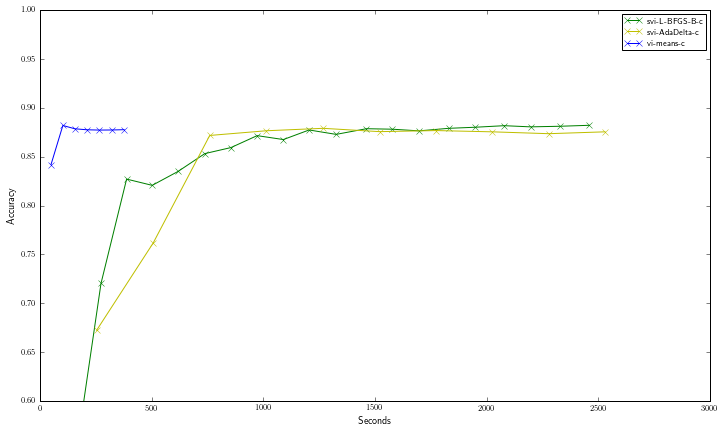

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [13]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)